https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

In [1]:
import pandas as pd
% matplotlib inline

In [2]:
from fastai2.vision.all import *
path = untar_data(URLs.PASCAL_2007)

/jet/var/python/lib/python3.6/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


This dataset is different from the ones we have seen before, in that it is not structured by filename or folder but instead comes with a CSV (comma-separated values) file telling us what labels to use for each image. We can inspect the CSV file by reading it into a Pandas DataFrame:

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
# You can access rows and columns of a DataFrame with the iloc property, as if it were a matrix:
df.iloc[:10,0]

0    000005.jpg
1    000007.jpg
2    000009.jpg
3    000012.jpg
4    000016.jpg
5    000017.jpg
6    000019.jpg
7    000020.jpg
8    000021.jpg
9    000023.jpg
Name: fname, dtype: object

In [5]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [8]:
# You can also grab a column by name by indexing into a DataFrame directly:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
5       000017.jpg
6       000019.jpg
7       000020.jpg
8       000021.jpg
9       000023.jpg
10      000024.jpg
11      000026.jpg
12      000030.jpg
13      000032.jpg
14      000033.jpg
15      000034.jpg
16      000035.jpg
17      000036.jpg
18      000039.jpg
19      000041.jpg
20      000042.jpg
21      000044.jpg
22      000046.jpg
23      000047.jpg
24      000048.jpg
25      000050.jpg
26      000051.jpg
27      000052.jpg
28      000060.jpg
29      000061.jpg
           ...    
4981    009898.jpg
4982    009900.jpg
4983    009902.jpg
4984    009904.jpg
4985    009905.jpg
4986    009908.jpg
4987    009911.jpg
4988    009913.jpg
4989    009917.jpg
4990    009918.jpg
4991    009920.jpg
4992    009923.jpg
4993    009926.jpg
4994    009932.jpg
4995    009935.jpg
4996    009938.jpg
4997    009939.jpg
4998    009940.jpg
4999    009942.jpg
5000    009944.jpg
5001    009945.jpg
5002    0099


## Constructing a DataBlock
How do we convert from a DataFrame object to a DataLoaders object? We generally suggest using the data block API for creating a DataLoaders object, where possible, since it provides a good mix of flexibility and simplicity. Here we will show you the steps that we take to use the data blocks API to construct a DataLoaders object in practice, using this dataset as an example.

As we have seen, PyTorch and fastai have two main classes for representing and accessing a training set or validation set:

Dataset:: A collection that returns a tuple of your independent and dependent variable for a single item
DataLoader:: An iterator that provides a stream of mini-batches, where each mini-batch is a couple of a batch of independent variables and a batch of dependent variables
On top of these, fastai provides two classes for bringing your training and validation sets together:

Datasets:: An object that contains a training Dataset and a validation Dataset
DataLoaders:: An object that contains a training DataLoader and a validation DataLoader
Since a DataLoader builds on top of a Dataset and adds additional functionality to it (collating multiple items into a mini-batch), it’s often easiest to start by creating and testing Datasets, and then look at DataLoaders after that’s working.

When we create a DataBlock, we build up gradually, step by step, and use the notebook to check our data along the way. This is a great way to make sure that you maintain momentum as you are coding, and that you keep an eye out for any problems. It’s easy to debug, because you know that if a problem arises, it is in the line of code you just typed!

Let’s start with the simplest case, which is a data block created with no parameters:

In [10]:
dblock = DataBlock()
dsets = dblock.datasets(df)
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [11]:
x,y = dsets.train[0]
x,y

(fname       009461.jpg
 labels       aeroplane
 is_valid          True
 Name: 4752, dtype: object, fname       009461.jpg
 labels       aeroplane
 is_valid          True
 Name: 4752, dtype: object)

As you can see, this simply returns a row of the DataFrame, twice. This is because by default, the data block assumes we have two things: input and target. We are going to need to grab the appropriate fields from the DataFrame, which we can do by passing get_x and get_y functions:

In [12]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('004185.jpg', 'cat')

In [13]:
# or
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('009422.jpg', 'bird')

We can see that the independent variable will need to be converted into a complete path, so that we can open it as an image, and the dependent variable will need to be split on the space character (which is the default for Python’s split function) so that it becomes a list:

In [14]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/jet/.fastai/data/pascal_2007/train/007889.jpg'), ['person'])

To actually open the image and do the conversion to tensors, we will need to use a set of transforms; block types will provide us with those. We can use the same block types that we have used previously, with one exception: the ImageBlock will work fine again, because we have a path that points to a valid image, but the CategoryBlock is not going to work. The problem is that block returns a single integer, but we need to be able to have multiple labels for each item. To solve this, we use a MultiCategoryBlock. This type of block expects to receive a list of strings, as we have in this case, so let’s test it out:

TensorMultiCategory
This is known as one-hot encoding. The reason we can’t easily just use a list of category indices is that each list would be a different length, and PyTorch requires tensors, where everything has to be the same length.

In [15]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

Let’s check what the categories represent for this example (we are using the convenient torch.where function, which tells us all of the indices where our condition is true or false):

In [16]:
idxs = torch.where(dsets.train[0][1]==1.)[0]

In [20]:
dsets.train[0][1]

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [21]:
idxs # position of not null value

tensor([8])

In [19]:
dsets.train.vocab[idxs]

(#1) ['chair']

We have ignored the column is_valid up until now, which means that DataBlock has been using a random split by default. To explicitly choose the elements of our validation set, we need to write a function and pass it to splitter (or use one of fastai's predefined functions or classes). It will take the items (here our whole DataFrame) and must return two (or more) lists of integers:

In [25]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [26]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))  #  every item is of the same size
dls = dblock.dataloaders(df)

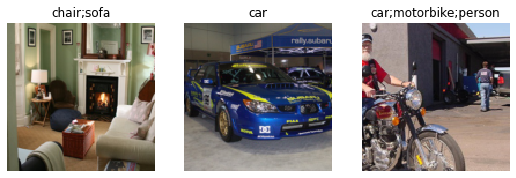

In [29]:
dls.show_batch(nrows=1, ncols=3)

In [30]:
learn = cnn_learner(dls, resnet18)

In [31]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [33]:
x.shape # 64 images in the batch, 3 layers 128x128 size

torch.Size([64, 3, 128, 128])

In [34]:
y.shape # 64 images in the batch and 20 prob. for each category

torch.Size([64, 20])

In [37]:
activs[0]

tensor([ 4.2498,  0.4158, -2.0177, -1.6430,  0.8910,  1.5947, -3.2137, -2.0354,
        -0.6951,  3.0322,  0.3539,  0.6835, -1.1333, -2.5901, -0.1887, -2.4009,
        -3.1612,  0.4715,  1.5098, -0.3048], grad_fn=<SelectBackward>)

In [38]:
# torch.where(condition, x, y) → Tensor
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()
# We don't actually need to tell fastai to use this loss function (although we can if we want) since it will be 
# automatically chosen for us. fastai knows that the DataLoaders has multiple category labels, so it will use 
# nn.BCEWithLogitsLoss by default.

PyTorch already provides this function for us. In fact, it provides a number of versions, with rather confusing names!

F.binary_cross_entropy and its module equivalent nn.BCELoss calculate cross-entropy on a one-hot-encoded target, but do not include the initial sigmoid. Normally for one-hot-encoded targets you'll want F.binary_cross_entropy_with_logits (or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross-entropy in a single function, as in the preceding example.

The equivalent for single-label datasets (like MNIST or the Pet dataset), where the target is encoded as a single integer, is F.nll_loss or nn.NLLLoss for the version without the initial softmax, and F.cross_entropy or nn.CrossEntropyLoss for the version with the initial softmax.

Since we have a one-hot-encoded target, we will use BCEWithLogitsLoss:

In [40]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.1050, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [41]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(1, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /jet/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947657,0.692314,0.243068,03:17
1,0.828592,0.568858,0.285737,03:14
2,0.606698,0.204343,0.812171,03:08
3,0.362163,0.126121,0.943088,03:15


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.140536,0.116365,0.942908,04:08


In [42]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.11636506021022797,0.9150994420051575]

In [43]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.11636506021022797,0.9403586983680725]

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [44]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default get_preds applies the output activation function (sigmoid, in this case) for us, so we'll need to tell accuracy_multi to not apply it:

In [46]:
accuracy_multi(preds, targs, thresh=0.5, sigmoid=False)

tensor(0.9595)

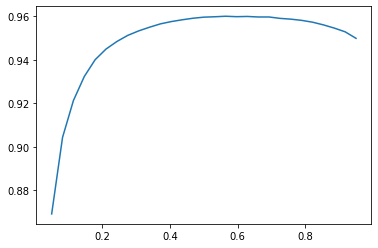

In [47]:
# We can now use this approach to find the best threshold level:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [54]:
accs

[tensor(0.8692),
 tensor(0.9043),
 tensor(0.9212),
 tensor(0.9323),
 tensor(0.9400),
 tensor(0.9449),
 tensor(0.9483),
 tensor(0.9512),
 tensor(0.9532),
 tensor(0.9549),
 tensor(0.9564),
 tensor(0.9575),
 tensor(0.9583),
 tensor(0.9590),
 tensor(0.9595),
 tensor(0.9597),
 tensor(0.9599),
 tensor(0.9597),
 tensor(0.9598),
 tensor(0.9596),
 tensor(0.9596),
 tensor(0.9590),
 tensor(0.9586),
 tensor(0.9580),
 tensor(0.9572),
 tensor(0.9560),
 tensor(0.9545),
 tensor(0.9528),
 tensor(0.9498)]

In [55]:
# find the Threshold with max accuracy
xs[torch.argmax(torch.FloatTensor(accs))]

tensor(0.5643)